[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Albly/Sparce_image_reconstruction/blob/master/notebooks/tests.ipynb)

In [1]:
from IPython import get_ipython
import os 
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 2

# check if we use colab or local machine
if 'google.colab' in str(get_ipython()):
    IS_COLAB = True
    print('Running on colab')
else:
    IS_COLAB = False
    print('Running on local machine')

if IS_COLAB:
    git_root = !git rev-parse --show-toplevel
    already_in_repo = os.path.exists(git_root[0])

    if not already_in_repo:
        !git clone https://github.com/Albly/Sparce_image_reconstruction $repo_dir

    sys.path.append('Sparce_image_reconstruction')

else:
    os.chdir(Path().absolute().parent)

Running on local machine


In [2]:
import torch
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm, trange
from scipy import sparse
import numpy as np

from metrics import *
from utils import *
from recoverers import activations as act
from recoverers.classical import *

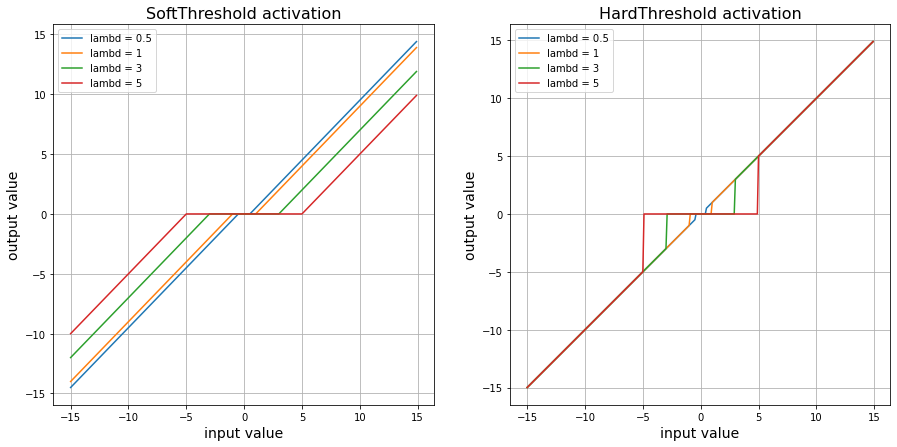

In [3]:
### Test of SoftThresholding and HardThresholding activation
x = torch.arange(-15,15, 0.1)
lambdas = [0.5, 1, 3, 5]

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)

# SoftThresholding
for lambd in lambdas:
    out = act.threshold(x,lambd,'soft')
    plt.plot(x,out, label = 'lambd = '+ str(lambd))

plt.grid()
plt.xlabel('input value', fontsize = 14)
plt.ylabel('output value', fontsize = 14)
plt.title('SoftThreshold activation', fontsize = 16)
plt.legend()

plt.subplot(1,2,2)
# SoftThresholding
for lambd in lambdas:
    out = act.threshold(x,lambd,'hard')
    plt.plot(x,out, label = 'lambd = '+ str(lambd))

plt.grid()
plt.legend()
plt.xlabel('input value', fontsize = 14)
plt.ylabel('output value', fontsize = 14)
plt.title('HardThreshold activation', fontsize = 16)

plt.show()



Iterative methods: for random signal

In [156]:
M = 250 # output vector size
N = 500 # input vector size

x = sparse.rand(m = N, n = 1, density = 0.1) # generate random sparce vector
A = np.random.normal(size=(M,N), scale = 1.0/np.sqrt(M)).astype(np.float32) # random matrix 
A = A/np.linalg.norm(A,2)

x = torch.tensor(x.A, dtype = torch.float32)
A = torch.tensor(A, dtype = torch.float32)

n = get_noise(A@x , 10)

y = A@x + n


In [157]:
x_hat, nmses = ista_denoise(y,A,x, 0.02, 2000)
x_hat2, nmses2 = fista_denoise(y,A,x, 0.02,2000)
x_hat3, nmses3 = amp_denoise(y,A,x, 0.45,500)

Text(0, 0.5, 'SNR [dB]')

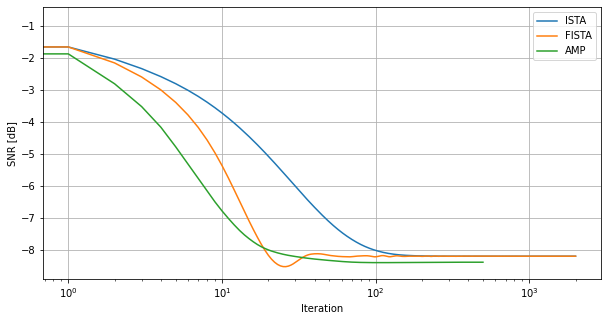

In [158]:
plt.figure(figsize = (10,5))
plt.plot(toDb(nmses), label ='ISTA')
plt.plot(toDb(nmses2), label ='FISTA')
plt.plot(toDb(nmses3), label ='AMP')
#plt.plot(toDb(torch.tensor(metrics)), label ='LISTA')

plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('SNR [dB]')

In [159]:
# lernable algorithm 

from recoverers.lernable import Lista

lista = Lista(A = A, layers = 16)
optimizer = torch.optim.Adam(lista.parameters(), lr = 1.0e-4)
loss_f = torch.nn.MSELoss()

losses = []
metrics = []
for i in range(1000):
    optimizer.zero_grad()

    x_hat = lista.forward(y)
    
    
    loss_value = loss_f(x_hat, x)
    metric = NMSE(x_hat, x)

    losses.append(loss_value.item())
    metrics.append(metric.item())

    loss_value.backward()
    optimizer.step()

Text(0, 0.5, 'SNR [dB]')

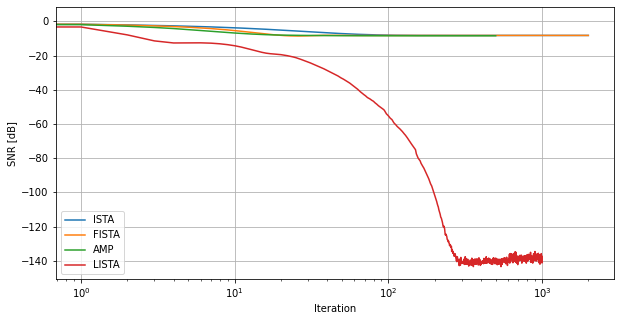

In [160]:
plt.figure(figsize = (10,5))
plt.plot(toDb(nmses), label ='ISTA')
plt.plot(toDb(nmses2), label ='FISTA')
plt.plot(toDb(nmses3), label ='AMP')
plt.plot(toDb(torch.tensor(metrics)), label ='LISTA')

plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('SNR [dB]')

Images


In [219]:
from sklearn.datasets import fetch_openml
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

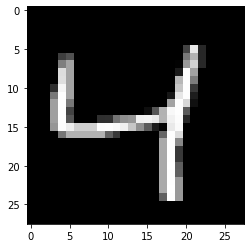

In [220]:
x = np.copy(X[2,:].reshape(28,28))
plt.imshow(x, cmap = 'gray')

0.15306122448979592


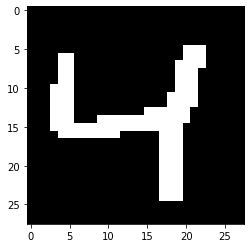

In [222]:
g = np.reshape(np.copy(x), (-1,1))
g[g!=0] = 10**6

print(len(g[g!=0]) /len(g)) 

plt.imshow(np.reshape(g,(28,28)), cmap = 'gray')

In [223]:
x = x.reshape(-1,1)

# measurement matrix
A = np.random.normal(size = (500 , 784), scale = 1.0/np.sqrt(500)).astype(np.float32) # random matrix 
A = A/np.linalg.norm(A,2)


A = torch.tensor(A,dtype = torch.float32)
x = torch.tensor(x,dtype = torch.float32)
n = get_noise(A@x, 40)

y = A@x+n


In [224]:
x_hat, nmses = ista_denoise(y,A,x, 0.1, 2000)
x_hat2, nmses2 = fista_denoise(y,A,x, 0.1,2000)
x_hat3, nmses3 = amp_denoise(y,A,x, 0.4, 500)
plt.plot(10*np.log10(nmses), label ='ista')
plt.plot(10*np.log10(nmses2), label ='fista')
plt.plot(10*np.log10(nmses3), label ='amp')
plt.xscale('log')
plt.legend()
plt.grid()

RuntimeError: expected scalar type Float but found ComplexDouble

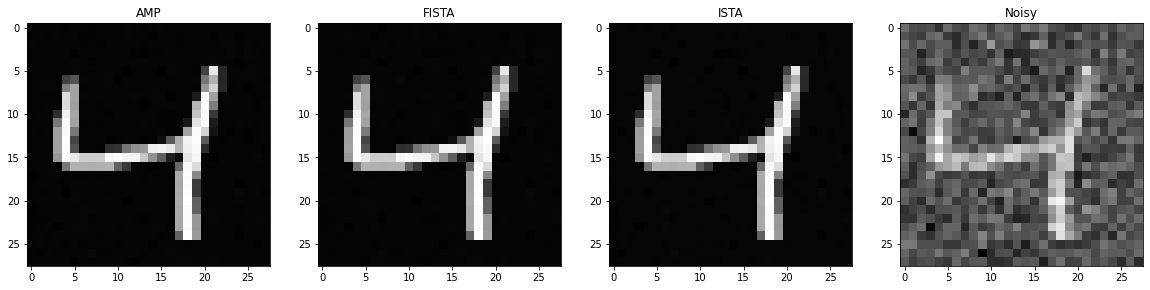

In [24]:
plt.figure(figsize =(20,5))

plt.subplot(1,4,1)
plt.imshow(x_hat3.reshape(28,28), cmap = 'gray')
plt.title('AMP')

plt.subplot(1,4,2)
plt.imshow(x_hat2.reshape(28,28), cmap = 'gray')
plt.title('FISTA')

plt.subplot(1,4,3)
plt.imshow(x_hat.reshape(28,28), cmap = 'gray')
plt.title('ISTA')

plt.subplot(1,4,4)
plt.title('Noisy')
plt.imshow((torch.linalg.pinv(A)@y) .reshape(28,28), cmap = 'gray')

Complex ???


In [178]:
import scipy
from scipy import linalg

def threshold_c(v, lambd):

    zero = torch.zeros_like(v.real)    
    sgn = torch.sgn(v)

    return sgn*torch.maximum(torch.abs(v) - lambd , zero)


In [225]:
x.shape

torch.Size([784, 1])

In [284]:
def get_RIP_FFT(M,N):
    assert M < N 
    F = torch.tensor(scipy.linalg.dft(N)/np.sqrt(N)) # DFT matrix
    idxs = torch.randperm(N)[:M]       # randomly choose M rows from N-size DFT matrix
    return F[idxs,:]

def get_sparcity(x):
    zeros = len(x[x < 0.01])
    return zeros/len(x)

M = 212
N = 784

A = get_RIP_FFT(M,N)

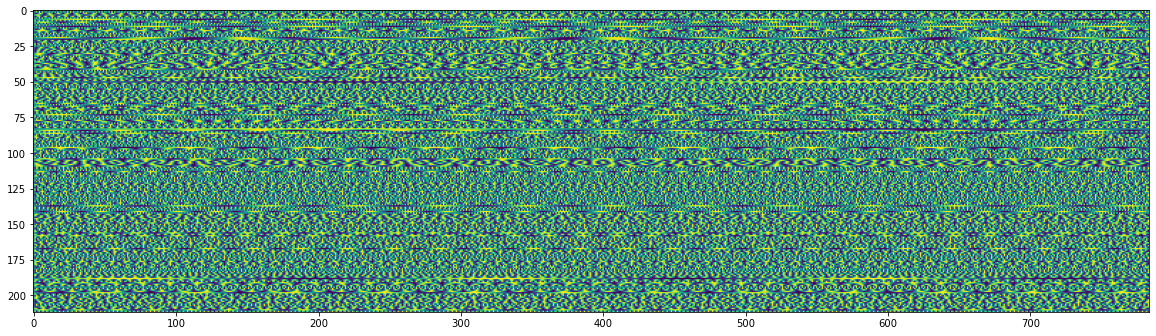

In [285]:
x = x.type(torch.complex128)
y = A@x
plt.figure(figsize=(20,10))
plt.imshow(A.imag)

In [289]:
def ista_iteration_c(y, A, x_hat, lambd):
    
    v = y - A @ x_hat                           
    r = x_hat + torch.conj(A).T @ v             
    x_hat = threshold_c(r, lambd )
    return x_hat                    

def ista_denoise_c(y,A,x, lambd, iterations):
    
    x_hat = torch.zeros(A.shape[1], 1, dtype= torch.complex128)
    metric = []

    for i in range(iterations):                 
        x_hat = ista_iteration_c(y,A, x_hat ,lambd)

        metric.append(NMSE(abs(x.real),abs(x_hat.real)))

    return x_hat, torch.tensor(metric)


def fista_iteration_c(y, A, x_hat, x_hat_prev, lambd, t):
    v = y - A @ x_hat                             
    r_add = (t-2)/(t+1) * (x_hat - x_hat_prev)  
    r = x_hat + torch.conj(A).T @ v + r_add                 
    x_hat_prev = x_hat                          
    x_hat = threshold_c(r, lambd)     

    return x_hat, x_hat_prev

def fista_denoise_c(y,A,x, lambd, iterations):

    x_hat = torch.zeros(A.shape[1], 1, dtype= torch.complex128)          
    x_hat_prev = torch.zeros(A.shape[1], 1, dtype= torch.complex128)     
    metric = []

    for t in range(1, iterations):              
        x_hat, x_hat_prev = fista_iteration_c(y,A, x_hat, x_hat_prev, lambd, t) 
        metric.append(NMSE(abs(x.real),abs(x_hat.real)))

    return x_hat, torch.tensor(metric)


def amp_iteration_c(y,A, x_hat, alpha, v_prev):
    
    b = 1/A.shape[0] * len(x_hat[x_hat!=0])

    v = y - A @x_hat + b*v_prev            
    lambd = alpha/math.sqrt(A.shape[0]) * torch.norm(v,2)
    r = x_hat + torch.conj(A).T @ v                                  
    x_hat = threshold_c(r,lambd)               
    v_prev = v                      

    return x_hat, v_prev


def amp_denoise_c(y,A, x , alpha, iterations):

    x_hat = torch.zeros(A.shape[1],1, dtype= torch.complex128)
    v_prev = torch.zeros(A.shape[0],1, dtype= torch.complex128)
    metric = []

    for _ in range(iterations):
        x_hat, v_prev = amp_iteration_c(y,A, x_hat,alpha, v_prev )
        metric.append(NMSE(abs(x.real),abs(x_hat.real)))                            

    return x_hat, torch.tensor(metric)


Text(0, 0.5, 'SNR [dB]')

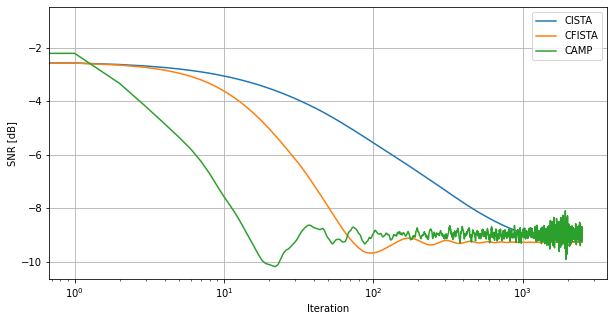

In [298]:
x_hat, nmses = ista_denoise_c(y, A,x, 1.9, 2500)
x_hat1, nmses1 = fista_denoise_c(y, A,x, 2.0, 2500)
x_hat2, nmses2 = amp_denoise_c(y, A,x, 0.68, 2500)

plt.figure(figsize = (10,5))
plt.plot(toDb(nmses), label ='CISTA')
plt.plot(toDb(nmses1), label ='CFISTA')
plt.plot(toDb(nmses2), label ='CAMP')


plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('SNR [dB]')

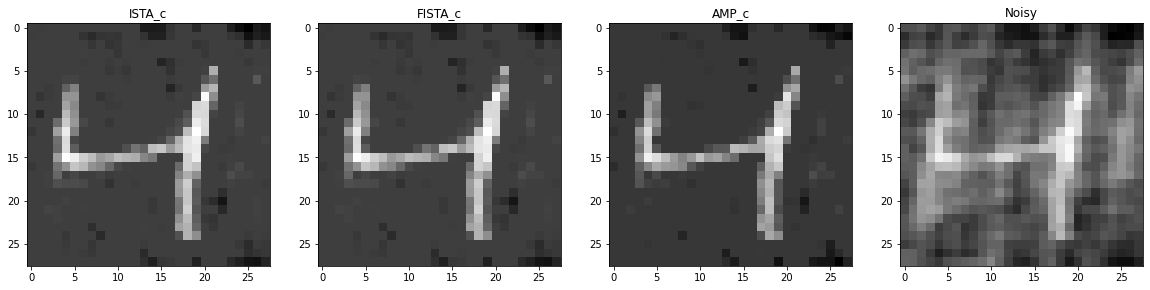

In [314]:
plt.figure(figsize =(20,5))

plt.subplot(1,4,1)
plt.imshow(x_hat.real.reshape(28,28), cmap = 'gray')
plt.title('ISTA_c')

plt.subplot(1,4,2)
plt.imshow(x_hat1.real.reshape(28,28), cmap = 'gray')
plt.title('FISTA_c')

plt.subplot(1,4,3)
plt.imshow(x_hat2.real.reshape(28,28), cmap = 'gray')
plt.title('AMP_c')

plt.subplot(1,4,4)
plt.title('Noisy')
plt.imshow(((torch.linalg.pinv(A)@y).real) .reshape(28,28), cmap = 'gray')